# Постановка задачи

Имеются изображения технологического процесса разлива металлических циллиндров. Есть риск нарушения технологии, когда стенки цилиндра не успевают застывать и трескаются. Не застывшый металл выливается, не образуя требуюмую заготовку. Необходимо оперативно определить лунку где произошел пролив. При этом пролив дольно редкое явление. Гораздо больше изображений можно собрать без пролива в лунке.

## Задача: построить модель (на основе автоэнкодера) определяющую состояние лунки пролив\не пролив.

title

Датесет
Данные - вырезанные изображения лунок. Ссыла на даасет

dataset
```
├── proliv  # изображения с проливами
|       ├── 000.jpg
│       ├── 001.jpg
│       │   └── ...
|
├── test  # тестовая выборка где перемешаны проливы и не_проливы
│       ├── imgs
│       │   ├── 000.jpg
│       │   ├── 001.jpg
│       │   └── ...
│       └── test_annotation.txt
|
├── train  #  обучающая выборка из не_проливов
|       ├── 000.jpg
│       ├── 001.jpg
│       └── ...
```
## План решения
1. Имплементировать или найти автоэкодер (можно для старта взять пример из лекции по автоэнкодерам)
2. Обучаем автоэнкодер на не_проливах (dataset\train)
3. Если через такой автоэнкодер прогнать изображение пролива, то MSE между входным изображением и выходным будет больше, чем если прогнать изображение без пролива. Следовательно, если определить некторое пороговое значение MSE, можно классифицировать изображение на классы пролив\не_пролив. Если MSE между входной картинкой и выходной больше фиксированного порога, то на изображении пролив.
4. В качестве loss функции используем MSE (как минимум для baseline)
5. Для определения порога используем изображения из dataset\proliv
6. Пишем метод классификации лунок
7. На изображениях из dataset\test тестируем качество. Считаем True_positive_rate и True_negative_rate.


# Imports

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torch.nn as nn
import torch.nn.functional as F

In [4]:
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import EarlyStopping, Callback


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

In [5]:
import matplotlib.patches as patches
from torchvision.transforms import ToPILImage
from PIL import Image

In [6]:
from glob import glob

In [7]:
np.seed = 42
torch.seed = 42

# Data

## utils

In [8]:
batch_size = 64
num_workers = 6

In [9]:
paths = glob('../data/hw_1/dataset/train/*')

In [10]:
SHAPE = (64, 64)

In [11]:
train_transforms = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

val_transforms = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

In [12]:
from dataset import AnomalyDataset, TestAnomalyDataset
        

In [13]:
test_fnames = []
gt_labels = []
with open('../data/hw_1/dataset/test/test_annotation.txt', 'r') as f:
    for line in f.readlines():
        fname, label = line.split()
        test_fnames.append(f"../data/hw_1/dataset/test/imgs/{fname}")
        gt_labels.append(int(label))

In [14]:
train_paths, val_paths = train_test_split(paths, test_size=0.1, random_state=111111)

In [15]:
train_set = AnomalyDataset(train_paths, train_transforms)
val_set = AnomalyDataset(val_paths, val_transforms)
test_set = TestAnomalyDataset(test_fnames, gt_labels, val_transforms)

In [16]:
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [17]:
proliv_dataset = AnomalyDataset(glob('../data/hw_1/dataset/proliv//*'), val_transforms)
proliv_loader = DataLoader(proliv_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [18]:
for images in train_loader:
    break

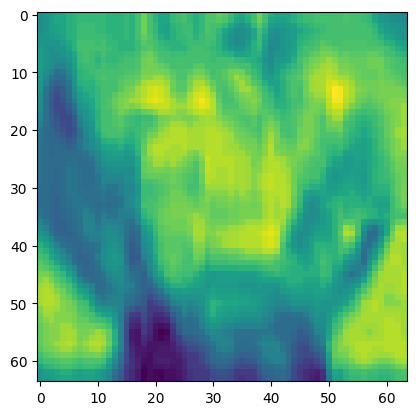

In [19]:
plt.imshow(images[0][0])

In [19]:
for images in proliv_loader:
    break

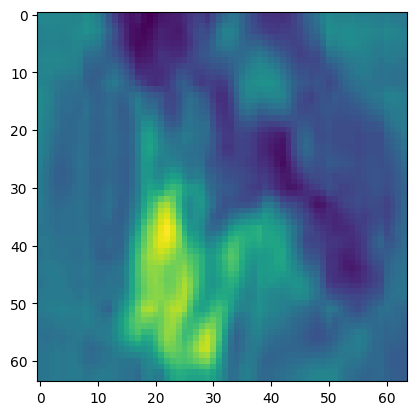

In [20]:
plt.imshow(images[0][0])

In [21]:
for images, labels in test_loader:
    break

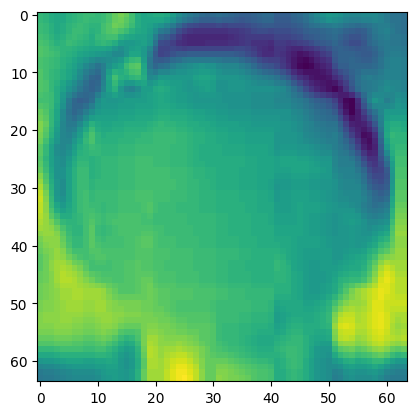

In [22]:
plt.imshow(images[labels==1][0][0])

# Model

## MNAD

### Encoder

In [20]:
class Encoder(nn.Module):
    def __init__(self, time_length=2, num_channels=1):
        super(Encoder, self).__init__()
        self.conv1 = self._build_basic_block(num_channels * (time_length - 1), 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = self._build_basic_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = self._build_basic_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = self._build_final_block(256, 512)
        self.batch_norm = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(inplace=False)

    def _build_basic_block(self, input_channels, output_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=False)
        )

    def _build_final_block(self, input_channels, output_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.conv4(x)
        return x

## Decoder

In [21]:
class Decoder(nn.Module):
    def __init__(self, time_length=2, num_channels=1):
        super(Decoder, self).__init__()
        
        self.conv = self._build_basic_block(1024, 512)
        self.upsample4 = self._build_upsample(512, 512)

        self.deconv3 = self._build_basic_block(512, 256)
        self.upsample3 = self._build_upsample(256, 256)

        self.deconv2 = self._build_basic_block(256, 128)
        self.upsample2 = self._build_upsample(128, 128)

        self.deconv1 = self._build_gen_block(128, num_channels, 64)

    def _build_basic_block(self, input_channels, output_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=False)
        )

    def _build_gen_block(self, input_channels, output_channels, intermediate_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=intermediate_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(intermediate_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(in_channels=intermediate_channels, out_channels=intermediate_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(intermediate_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(in_channels=intermediate_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def _build_upsample(self, input_channels, output_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=False)
        )

    def forward(self, x):
        x = self.upsample4(self.conv(x))
        x = self.upsample3(self.deconv3(x))
        x = self.upsample2(self.deconv2(x))
        return self.deconv1(x)

## Memory

In [22]:
# utils
import functools
import random

def random_uniform(shape, low, high, use_cuda):
    """Generate a tensor with values uniformly distributed between `low` and `high`."""
    x = torch.rand(*shape) * (high - low) + low
    return x.cuda() if use_cuda else x

def distance(a, b):
    """Calculate the Euclidean distance between tensors `a` and `b`."""
    return torch.sqrt(((a - b) ** 2).sum()).unsqueeze(0)

def distance_batch(a, b):
    """Calculate batch-wise Euclidean distance between tensors `a` and `b`."""
    bs = a.shape[0]
    return torch.stack([distance(a[i], b) for i in range(bs)])

def multiply(x):
    """Flatten matrix into a vector."""
    return functools.reduce(lambda x, y: x * y, x, 1)

def flatten(x):
    """Flatten tensor `x` into a vector."""
    count = multiply(x.size())
    return x.view(count)

def index(batch_size, x):
    """Create an index tensor for `x` based on `batch_size`."""
    idx = torch.arange(0, batch_size, dtype=torch.long)
    idx = idx.unsqueeze(-1)
    return torch.cat((idx, x), dim=1)

def memory_loss(memory):
    """Calculate memory loss for a given memory tensor."""
    m, _ = memory.size()
    memory_t = memory.t()
    similarity = torch.matmul(memory, memory_t) / 2 + 0.5
    identity_mask = torch.eye(m, device=memory.device)
    sim = torch.abs(similarity - identity_mask)
    return torch.sum(sim) / (m * (m - 1))

In [23]:

class Memory(nn.Module):
    def __init__(self, memory_size, feature_dim, key_dim,  temp_update, temp_gather):
        super(Memory, self).__init__()
        self.memory_size = memory_size
        self.feature_dim = feature_dim
        self.key_dim = key_dim
        self.temp_update = temp_update
        self.temp_gather = temp_gather
    
    def get_update_query(self, mem, max_indices, update_indices, score, query, train):
        m, d = mem.size()
        if train:
            query_update = torch.zeros((m,d)).cuda()
            for i in range(m):
                idx = torch.nonzero(max_indices.squeeze(1)==i)
                a, _ = idx.size()
                if a != 0:
                    query_update[i] = torch.sum(((score[idx,i] / torch.max(score[:,i])) *query[idx].squeeze(1)), dim=0)
                else:
                    query_update[i] = 0 
        
       
            return query_update 
    
        else:
            query_update = torch.zeros((m,d)).cuda()
            for i in range(m):
                idx = torch.nonzero(max_indices.squeeze(1)==i)
                a, _ = idx.size()
                if a != 0:
                    query_update[i] = torch.sum(((score[idx,i] / torch.max(score[:,i])) *query[idx].squeeze(1)), dim=0)
                else:
                    query_update[i] = 0 
            
            return query_update

    def get_score(self, mem, query):
        bs, h,w,d = query.size()
        m, d = mem.size()
        
        score = torch.matmul(query, torch.t(mem))# b X h X w X m
        score = score.view(bs*h*w, m)# (b X h X w) X m
        
        score_query = F.softmax(score, dim=0)
        score_memory = F.softmax(score,dim=1)
        
        return score_query, score_memory
    
    def forward(self, query, keys, train=True):
        batch_size, dims,h,w = query.size() # b X d X h X w
        query = F.normalize(query, dim=1)
        query = query.permute(0,2,3,1) # b X h X w X d
        
        if train:
            separateness_loss, compactness_loss = self.gather_loss(query, keys, train)
            updated_query, softmax_score_query,softmax_score_memory = self.read(query, keys)
            updated_memory = self.update(query, keys, train)
            return updated_query, updated_memory, softmax_score_query, softmax_score_memory, separateness_loss, compactness_loss
        else:
            compactness_loss, query_re, top1_keys, keys_ind = self.gather_loss(query,keys, train)
            updated_query, softmax_score_query,softmax_score_memory = self.read(query, keys)
            updated_memory = keys
            return updated_query, updated_memory, softmax_score_query, softmax_score_memory, query_re, top1_keys,keys_ind, compactness_loss
        
    def update(self, query, keys,train):
        batch_size, h,w,dims = query.size() # b X h X w X d 
        softmax_score_query, softmax_score_memory = self.get_score(keys, query)
        query_reshape = query.contiguous().view(batch_size*h*w, dims)
        _, gathering_indices = torch.topk(softmax_score_memory, 1, dim=1)
        _, updating_indices = torch.topk(softmax_score_query, 1, dim=0)
        
        if train:
            query_update = self.get_update_query(keys, gathering_indices, updating_indices, softmax_score_query, query_reshape,train)
            updated_memory = F.normalize(query_update + keys, dim=1)
        else:
            query_update = self.get_update_query(keys, gathering_indices, updating_indices, softmax_score_query, query_reshape, train)
            updated_memory = F.normalize(query_update + keys, dim=1)
        return updated_memory.detach()
        
        
    def pointwise_gather_loss(self, query_reshape, keys, gathering_indices, train):
        n,dims = query_reshape.size() # (b X h X w) X d
        pointwise_loss = F.mse_loss(query_reshape, keys[gathering_indices].squeeze(1).detach(), reduction="none")
        return pointwise_loss
        
    def gather_loss(self,query, keys, train):
        batch_size, h,w,dims = query.size() # b X h X w X d
        if train:
            softmax_score_query, softmax_score_memory = self.get_score(keys, query)
            query_reshape = query.contiguous().view(batch_size*h*w, dims)
            _, gathering_indices = torch.topk(softmax_score_memory, 2, dim=1)
        
            pos = keys[gathering_indices[:,0]]
            neg = keys[gathering_indices[:,1]]
            top1_loss = F.mse_loss(query_reshape, pos.detach())
            gathering_loss = F.triplet_margin_loss(query_reshape,pos.detach(), neg.detach(), margin=1.0)
            
            return gathering_loss, top1_loss
        
            
        else:
            softmax_score_query, softmax_score_memory = self.get_score(keys, query)
            query_reshape = query.contiguous().view(batch_size*h*w, dims)
        
            _, gathering_indices = torch.topk(softmax_score_memory, 1, dim=1)
            gathering_loss = F.mse_loss(query_reshape, keys[gathering_indices].squeeze(1).detach())
            return gathering_loss, query_reshape, keys[gathering_indices].squeeze(1).detach(), gathering_indices[:,0]
            
        
        
    
    def read(self, query, updated_memory):
        batch_size, h,w,dims = query.size() # b X h X w X d

        softmax_score_query, softmax_score_memory = self.get_score(updated_memory, query)

        query_reshape = query.contiguous().view(batch_size*h*w, dims)
        
        concat_memory = torch.matmul(softmax_score_memory.detach(), updated_memory) # (b X h X w) X d
        updated_query = torch.cat((query_reshape, concat_memory), dim = 1) # (b X h X w) X 2d
        updated_query = updated_query.view(batch_size, h, w, 2*dims)
        updated_query = updated_query.permute(0,3,1,2)
        
        return updated_query, softmax_score_query, softmax_score_memory

In [24]:
class Autoencoder(nn.Module):
    def __init__(self, num_channels=1, time_length=2, memory_size=10, feature_dim=512, key_dim=512, temp_update=0.1, temp_gather=0.1):
        super(Autoencoder, self).__init__()
        
        self.encoder = Encoder(time_length, num_channels)
        self.decoder = Decoder(time_length, num_channels)
        # self.keys = F.normalize(torch.rand((memory_size, feature_dim), dtype=torch.float), dim=1)
        self.register_buffer("keys", F.normalize(torch.rand((memory_size, feature_dim), dtype=torch.float, requires_grad=False), dim=1))
        self.memory = Memory(memory_size, feature_dim, key_dim, temp_update, temp_gather)

    def forward(self, x, train=True):
        features = self.encoder(x)
        if train:
            updated_features, keys, softmax_score_query, softmax_score_memory, separateness_loss, compactness_loss = self.memory(features, self.keys, train)
            output = self.decoder(updated_features)
            return output, features, updated_features, keys, softmax_score_query, softmax_score_memory, separateness_loss, compactness_loss
        
        else:
            updated_features, keys, softmax_score_query, softmax_score_memory, query, top1_keys, keys_ind, compactness_loss = self.memory(features, self.keys, train)
            output = self.decoder(updated_features)
            return output, features, updated_features, keys, softmax_score_query, softmax_score_memory, query, top1_keys, keys_ind, compactness_loss


# Training loop

In [25]:
class LModule(L.LightningModule):
    def __init__(self, model: nn.Module, l_sep: float = 0.1, l_comp: float = 0.1):
        super(LModule, self).__init__()
        self.model = model
        self.optimal_threshold = 0
        self.l_sep = l_sep
        self.l_comp = l_comp

    def forward(self, x):
        outputs, _, _, m_items, softmax_score_query, softmax_score_memory, separateness_loss, compactness_loss = self.model(x, True)
        return outputs

    def training_step(self, images, batch_idx):
        outputs, _, _, m_items, _, _, sep_loss, comp_loss = self.model.forward(images, True)
        px_loss = F.mse_loss(outputs, images)
        
        loss = px_loss + self.l_sep * sep_loss + self.l_comp * comp_loss
        self.log('loss/train', loss)
        self.log('loss/train/separatness', sep_loss)
        self.log('loss/train/compactness', comp_loss)
        self.log('loss/train/pixel_mse', px_loss)
        return loss

    def validation_step(self, images, batch_idx):
        outputs, _, _, _, _, _, _, _, _, compactness_loss = self.model(images, train=False)
        
        px_loss = F.mse_loss(outputs, images)
        self.log('loss/val/pixel_mse', px_loss)
        self.log('loss/val/compactness', compactness_loss)

    def configure_optimizers(self):
        params = list(model.encoder.parameters()) + list(model.decoder.parameters()) 
        optim = torch.optim.AdamW(params, lr=3e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=100)
        return [optim], [scheduler]

In [26]:
every_n_epochs = 5

In [27]:

callbacks = []

In [28]:
max_epochs = 100
log_every_n_steps = 100

In [29]:
model = Autoencoder()

In [127]:
# torch.save(model.state_dict(), 'a.pt', )

In [128]:
# module = LModule.load_from_checkpoint('../logs/deep_gen/mnad/checkpoints/epoch=5-step=846.ckpt', model=model, memory=memory)

In [129]:
wandb_logger = WandbLogger(project='deep_gen', save_dir='../logs', version='mnad_memgrad')
module = LModule(model)
trainer = L.Trainer(
    callbacks=callbacks,
    max_epochs=15,
    log_every_n_steps=log_every_n_steps,
    logger=wandb_logger,
)
trainer.fit(module, train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ionov/.local/lib/python3.8/site-packages/lightning/pytorch/loggers/wandb.py:390: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/ionov/.local/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory ../logs/deep_gen/mnad2/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type        | Params
--------------------------------------
0 | model | Autoencoder | 17.2 M
--------------------------------------
17.2 M    Trainable params
0         Non-trainable params
17.2 M    Total params
68.776    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [43]:
# torch.save(model.state_dict(), 'weights.pt', )

In [30]:
model.load_state_dict(torch.load('weights.pt'))

<All keys matched successfully>

In [31]:
# model.to('cpu')
model.eval()
print()

In [32]:
model.to('cuda')

Autoencoder(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [33]:
device = 'cuda'

In [59]:
mse_normal = []
for images in val_loader:
    with torch.inference_mode():
        out = model(images.to(device))[0]
        mse = F.mse_loss(out, images.to(device), reduction='none').mean([1, 2, 3])
    mse_normal.extend(mse.detach().cpu().numpy())
mse_normal = np.array(mse_normal)

In [60]:
mse_anomaly = []
for images in proliv_loader:
    with torch.inference_mode():
        out = model(images.to(device))[0]
        mse = F.mse_loss(out, images.to(device), reduction='none').mean([1, 2, 3])
    mse_anomaly.extend(mse.detach().cpu().numpy())
mse_anomaly = np.array(mse_anomaly)

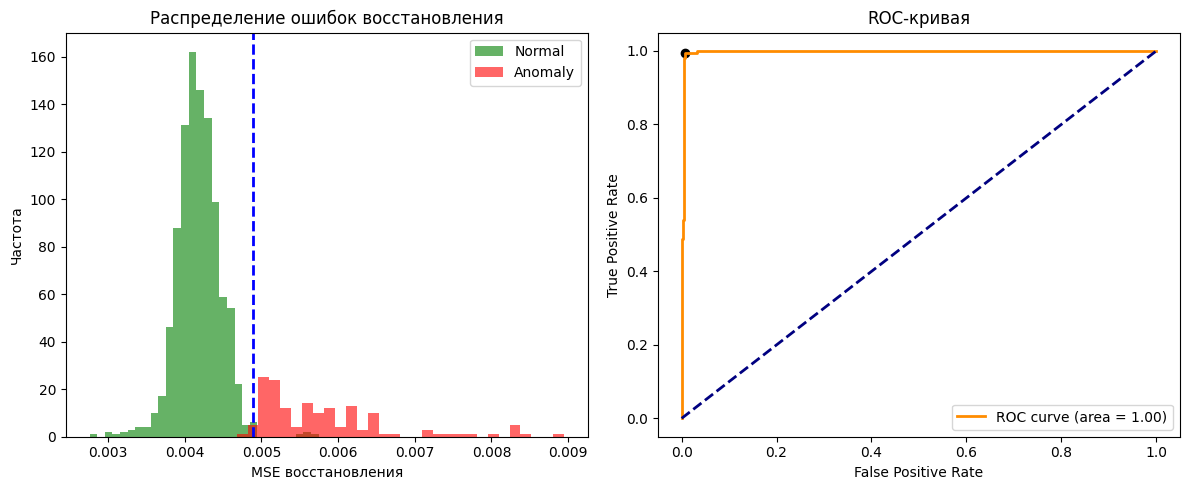

In [61]:
labels = np.array([0] * len(mse_normal) + [1] * len(mse_anomaly))
mse_values = np.concatenate([mse_normal, mse_anomaly])
fpr, tpr, thresholds = roc_curve(labels, mse_values)
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(mse_normal, bins=30, alpha=0.6, color='g', label='Normal')
plt.hist(mse_anomaly, bins=30, alpha=0.6, color='r', label='Anomaly')
plt.axvline(optimal_threshold, color='b', linestyle='dashed', linewidth=2)
plt.title('Распределение ошибок восстановления')
plt.xlabel('MSE восстановления')
plt.ylabel('Частота')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='black')
plt.title('ROC-кривая')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
optimal_threshold

0.004884258

In [63]:
test_root = '../data/hw_1/dataset/test/imgs'

In [64]:
test_fnames = []
gt_labels = []
with open('../data/hw_1/dataset/test/test_annotation.txt', 'r') as f:
    for line in f.readlines():
        fname, label = line.split()
        test_fnames.append(fname)
        gt_labels.append(int(label))

In [65]:
gt_labels = np.array(gt_labels)

In [67]:
pred_errors = []
for fname in test_fnames:
    img = Image.open(f"{test_root}/{fname}").convert('L')
    tensor = val_transforms(img).to(device)
    with torch.inference_mode():
        out = model(tensor.unsqueeze(0))[0]
        mse = F.mse_loss(out.squeeze(0), tensor)
        pred_errors.append(mse.item())

In [68]:
pred_errors = np.array(pred_errors)

In [69]:
pred_labels = pred_errors > optimal_threshold

In [70]:
tn, fp, fn, tp = confusion_matrix(gt_labels, pred_labels).ravel()

# Расчет TPR и TNR
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"True Negative Rate (TNR): {tnr:.4f}")

True Positive Rate (TPR): 0.7519
True Negative Rate (TNR): 0.8592


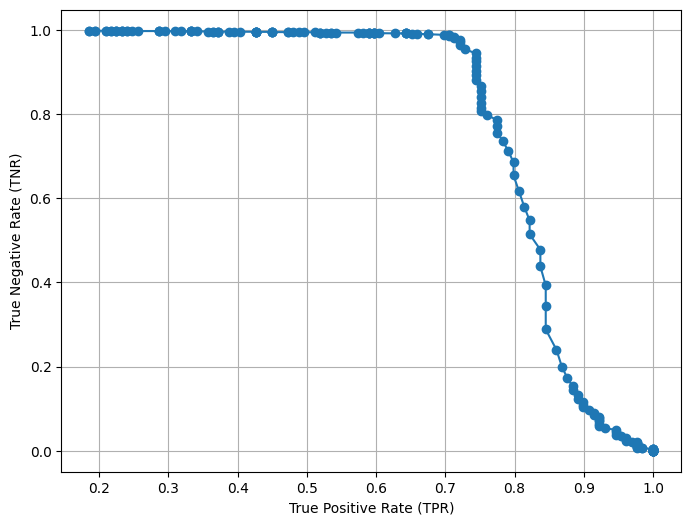

In [71]:
thresholds = np.linspace(optimal_threshold * 0.5, optimal_threshold * 1.5, 200)

tpr_list = []
tnr_list = []

for threshold in thresholds:
    pred_labels = pred_errors > threshold
    tn, fp, fn, tp = confusion_matrix(gt_labels, pred_labels).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    tpr_list.append(tpr)
    tnr_list.append(tnr)

plt.figure(figsize=(8, 6))
plt.plot(tpr_list, tnr_list, marker='o')
plt.xlabel('True Positive Rate (TPR)')
plt.ylabel('True Negative Rate (TNR)')
plt.grid(True)
plt.show()

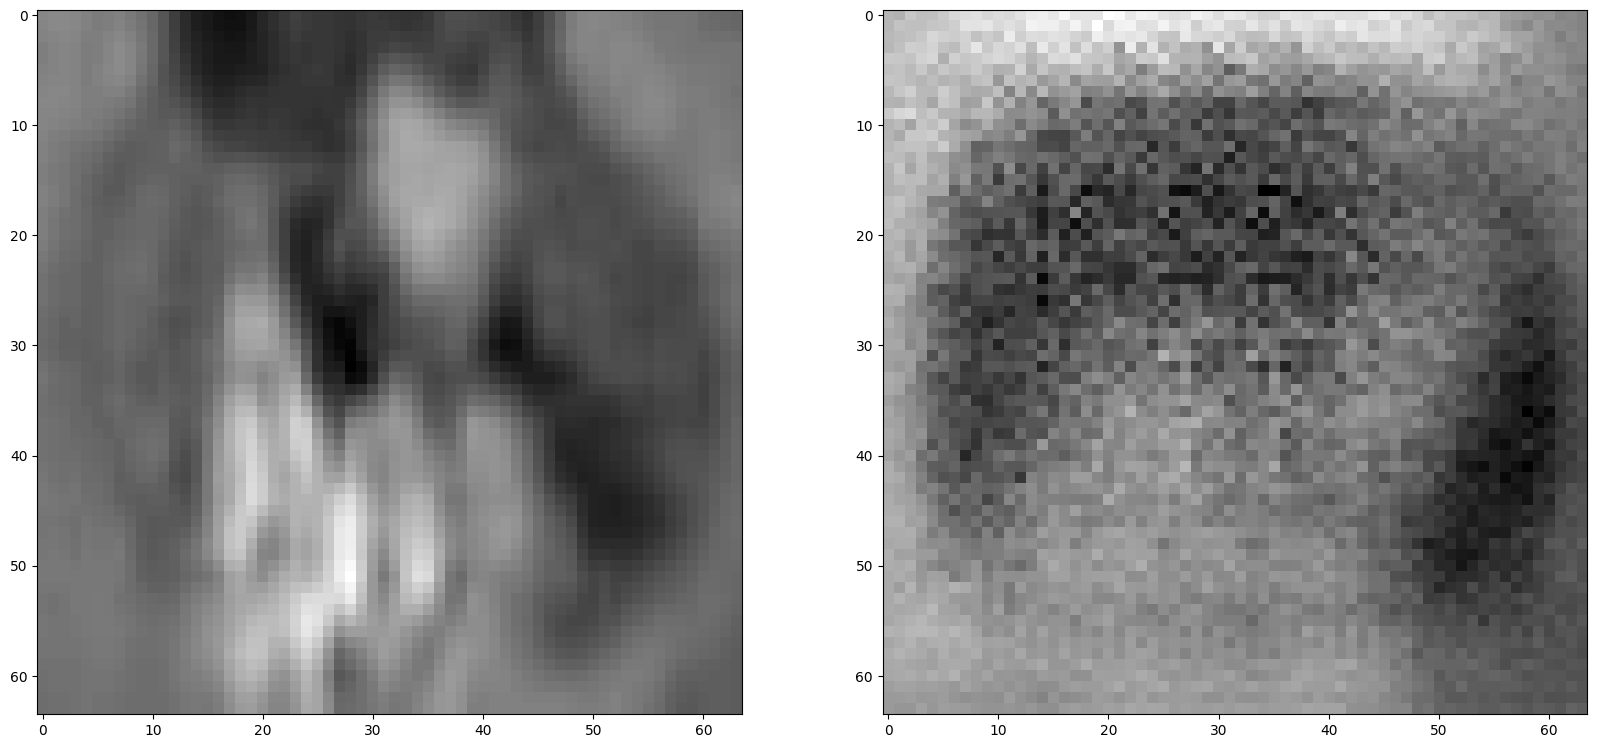

In [72]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 40))

axes[0].imshow(images.detach().cpu().numpy()[0][0], cmap='gray')
axes[1].imshow(out.detach().cpu().numpy()[0][0], cmap='gray')

# Memory clusters

В оригинальном репозитории нет скриптов, как они визуализировали память и фичи.
В целом, вопрос к их реализации и качеству кода... дебаг модуля памяти занял значительное время.

Поэтому я визуализировал фичи модуля памяти по всем семплам из трейна.

In [34]:
keyss = []
querys = []

for images in train_loader:
    with torch.inference_mode():
        out = model(images.to(device), train=False)
        output, features, updated_features, keys, softmax_score_query, softmax_score_memory, query, top1_keys, keys_ind, compactness_loss = out
        keyss.append(keys)
        querys.append(query)

In [58]:
query = torch.concatenate(querys)

In [38]:
keys = torch.concatenate(keyss)

In [39]:
keys.shape

torch.Size([1410, 512])

In [40]:
from sklearn.manifold import TSNE

In [65]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5)

In [66]:
keys_tsne = tsne.fit_transform(keys.detach().cpu().numpy())

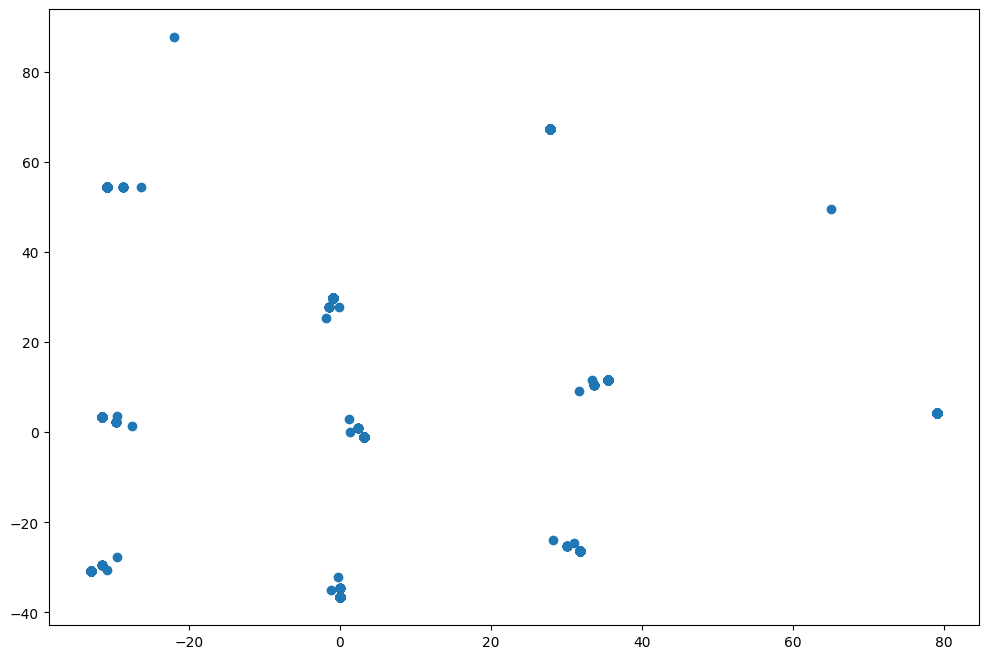

In [67]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(keys_tsne[:, 0], keys_tsne[:, 1])

In [68]:
tsne = TSNE(n_components=2, random_state=42, perplexity=10)